In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import sys
sys.path.insert(0,"../src/")

from main import FrankeFunction
from linear_regression import *
from bootstrap import *
from cross_validation import *
from stat_tools import *
import unit_tests

In [2]:
# Make sure things are working as expected
unit_tests.OLS_unit_test()
unit_tests.OLS_SVD_unit_test()
unit_tests.Ridge_2D_unit_test()

# Problem 1a)

- Play around with the franke funtion both with & without noise!
- Perform OLS up to 5th order
- Compute R2
- Compute MSE
- Find confidence interval of beta

In [3]:
# Generate test data
n = 300 # Number of data points

x_dat = np.random.uniform(0, 1, n)
y_dat = np.random.uniform(0, 1, n)
z_dat = FrankeFunction(x_dat, y_dat)
z_dat_noisy = z_dat + np.random.normal(0, 1, n) * 0.20

scaler = StandardScaler()

# Wrap the analysis in a function to duplicate for Clean & Noisy data
def p1_analysis(x, y, z, degrees):
    
    mse = pd.DataFrame(columns=["train", "test"], index = degrees)
    r2 = pd.DataFrame(columns=["train", "test"], index = degrees)

    #var_b = pd.DataFrame(indices=degrees)
    
    for i, deg in enumerate(degrees):
        X = design_matrix_2D(x, y, deg)
        # Split data, but don't shuffle. OK since data is already randomly sampled! 
        # Fasilitates a direct comparrison of the clean & Noisy data
        X_train, X_test, z_train, z_test = train_test_split(X, z, test_size = 0.2, shuffle=False)
        # Normalize data sets
        X_train = scaler.fit_transform(X_train)
        X_train[:, 0] = np.ones(X_train.shape[0])
        X_test = scaler.fit_transform(X_test)
        X_test[:, 0] = np.ones(X_test.shape[0])

        beta = OLS_SVD_2D(X_train, z_train)
        
        mse["train"][i] = MSE(z_train, X_train @ beta)
        mse["test"][i] = MSE(z_test, X_test @ beta)

        r2["train"][i] = R2(z_train, X_train @ beta)
        r2["test"][i] = R2(z_test, X_test @ beta)

        #var_b.append([deg, var_beta(z_train, X_train)])
        
    return mse, r2, 0#, var_b

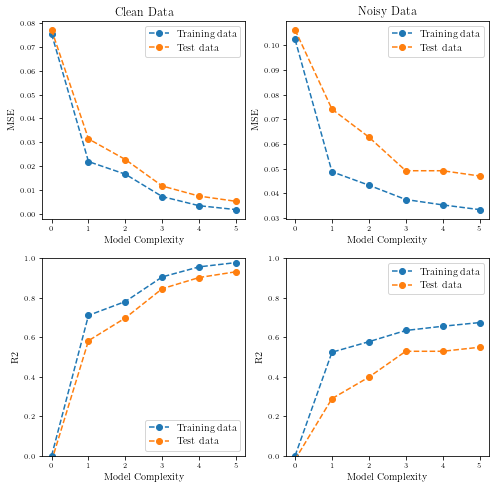

In [4]:
degrees = np.arange(0, 6) # Degrees of the polynomial

# Generate data
MSE_clean, R2_clean, var_b_clean = p1_analysis(x_dat, y_dat, z_dat, degrees)
MSE_noisy, R2_noisy, var_b_noisy = p1_analysis(x_dat, y_dat, z_dat_noisy,degrees)

plt.figure(figsize=(8,8))
# Plot Clean MSE
plt.subplot(221)
plt.plot(degrees, MSE_clean["train"],"o--", label = "Training data")
plt.plot(degrees, MSE_clean["test"],"o--", label = "Test data")
plt.xlabel("Model Complexity")
plt.ylabel("MSE")
plt.title("Clean Data")
plt.legend()
# Plot Noisy MSE
plt.subplot(222)
plt.plot(degrees, MSE_noisy["train"],"o--", label = "Training data")
plt.plot(degrees, MSE_noisy["test"],"o--", label = "Test data")
plt.xlabel("Model Complexity")
plt.ylabel("MSE")
plt.title("Noisy Data")
plt.legend()

# Plot Clean R2
plt.subplot(223)
plt.plot(degrees, R2_clean["train"],"o--", label = "Training data")
plt.plot(degrees, R2_clean["test"],"o--", label = "Test data")
plt.xlabel("Model Complexity")
plt.ylabel("R2")
plt.ylim([0,1])
plt.legend()

# Plot Noisy R2
plt.subplot(224)
plt.plot(degrees, R2_noisy["train"],"o--", label = "Training data")
plt.plot(degrees, R2_noisy["test"],"o--", label = "Test data")
plt.xlabel("Model Complexity")
plt.ylabel("R2")
plt.ylim([0,1])
plt.legend()

# Problem 1b)
- Replicate Fig 2.11 from Hastie et al using bootstrap
- Bias variance analysis

In [5]:
def p2_analysis(x, y, z, degrees, N_bootstraps):
    
    columns = [
        "MSE train", "MSE test",
        #"R2 train", "R2 test"
        "Bias train", "Bias test",
        "Variance train", "Variance test"
    ]
    
    df = pd.DataFrame(columns=columns)
    
    for i, deg in enumerate(degrees):
        X = design_matrix_2D(x, y, deg)
        # Split data, but don't shuffle. OK since data is already randomly sampled! 
        # Fasilitates a direct comparrison of the clean & Noisy data
        X_train, X_test, z_train, z_test = train_test_split(X, z, test_size = 0.2, shuffle=False)
        
        # Normalize data sets
        X_train = scaler.fit_transform(X_train)
        X_train[:, 0] = np.ones(X_train.shape[0])
        X_test = scaler.fit_transform(X_test)
        X_test[:, 0] = np.ones(X_test.shape[0])
        
        output = bootstrap(
            X_train, 
            X_test, 
            z_train, 
            z_test,
            bootstraps = N_bootstraps,
            regression = linear_regression.OLS_SVD_2D
        )

        df = df.append(pd.DataFrame(output, index=[deg]))
    
    return df

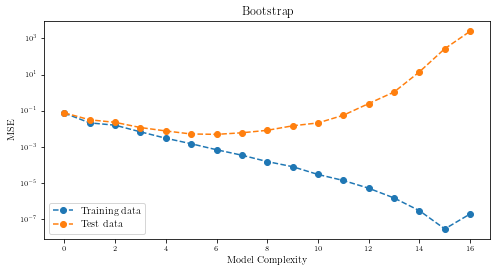

In [6]:
degrees = np.arange(0, 17) # This stop working for 12< possible bug in OLS_SVD?
N_bootstraps = 500
data_bootstrap = p2_analysis(x_dat, y_dat, z_dat, degrees, N_bootstraps)


plt.figure(figsize=(8,4))

plt.semilogy(degrees, data_bootstrap["MSE train"],"o--", label = "Training data")
plt.semilogy(degrees, data_bootstrap["MSE test"],"o--", label = "Test data")
plt.xlabel("Model Complexity")
plt.ylabel("MSE")
plt.title("Bootstrap")
plt.legend(loc="lower left")



In [7]:
data_bootstrap

,MSE train,MSE test,Bias train,Bias test,Variance train,Variance test,R2 train,R2 test
0,7.491455e-02,0.077328,0,0,0,0,0.0,0.0
1,2.152869e-02,0.031807,0,0,0,0,0.0,0.0
2,1.605444e-02,0.023059,0,0,0,0,0.0,0.0
3,6.876743e-03,0.011897,0,0,0,0,0.0,0.0
4,3.049717e-03,0.007702,0,0,0,0,0.0,0.0
5,1.513272e-03,0.005242,0,0,0,0,0.0,0.0
6,7.047389e-04,0.004993,0,0,0,0,0.0,0.0
7,3.516318e-04,0.006101,0,0,0,0,0.0,0.0
8,1.562447e-04,0.008353,0,0,0,0,0.0,0.0
9,8.155225e-05,0.014816,0,0,0,0,0.0,0.0


# Problem 1c)
- Do cross validation on the dataset. Compare MSE with bootstrap

In [8]:
def p3_analysis(x, y, z, degrees, k):
    
    columns = [
        "MSE train", "MSE test",
        "R2 train", "R2 test"
        #"Variance train", "Variance test"
        #"Bias train", "Bias test"
    ]
    
    data = pd.DataFrame(columns=columns, index=degrees)
    test_indices, train_indices = k_fold_selection(z, k=k)
    
    for i, deg in enumerate(degrees):
        X = design_matrix_2D(x, y, deg)
    
        # Normalize the design matrix
        X = scaler.fit_transform(X)
        X[:, 0] = np.ones(X.shape[0])
        
        output = cross_validation(X, z, k_folds = k)
        
        for col in columns:
            data[col][deg] = output[col].mean()
        
        
    return data

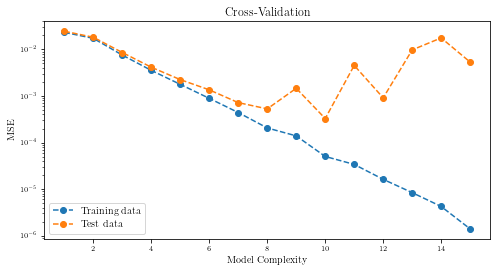

In [9]:
degrees = np.arange(1, 16)
dat_cross = p3_analysis(x_dat, y_dat, z_dat, degrees, k=55)

plt.figure(figsize=(8,4))

plt.semilogy(degrees, dat_cross["MSE train"],"o--", label = "Training data")
plt.semilogy(degrees, dat_cross["MSE test"],"o--", label = "Test data")
plt.xlabel("Model Complexity")
plt.ylabel("MSE")
plt.title("Cross-Validation")
plt.legend(loc="lower left")

# Problem 1d)
- Do same analysis, but with Ridge regression

# Problem 1e)
- Do Same analysis, but with Lasso Regression

# Problem 1f)
- Download real data!

# Problem 1d)
= Analyse real data using wisdom gained from Franke Function!

In [10]:
def k_fold_split(X, z, k_folds = 5):
    perm = np.random.permutation(len(z))
    perm = np.split(perm, k_folds)
    return perm

X =  np.ones([5, 5])
z = np.ones([5])
for i in range(5):
    X[i] *= i
    z[i] *= i

In [11]:
cols = ["A", "B", "C"]
indices = np.arange(3, 7)
df = pd.DataFrame(columns = cols)


df2 = pd.DataFrame({
    "A" : [1],
    "B" : [2],
    "C" : [3],
}, index = [4])


df = df.append(df2)
df2 = pd.DataFrame({
    "A" : [1],
    "B" : [2],
    "C" : [3],
}, index = [2])
df = df.append(df2 * 2)
df2 = pd.DataFrame({
    "A" : [1],
    "B" : [2],
    "C" : [3],
}, index = [1])
df = df.append(df2 * 3)

print(df)

   A  B  C
4  1  2  3
2  2  4  6
1  3  6  9
